In [4]:
from collections.abc import Iterable
import itertools
import json
import random
import pandas as pd

# data & plotting stuff
from matplotlib import pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm

# web3 stuff
from solc import compile_standard
from eth_tester import PyEVMBackend, EthereumTester
import web3
web3.eth.handleRevert = True

In [5]:
# save results of previous runs
HASH_TO_GAS_COST = {}

In [22]:
def _median(arr):
    arr_copy = arr[:]
    arr_copy.sort()
    n = len(arr)
    '''
    if n % 2 == 1:
        return arr_copy[n // 2]
    else:
        return (arr_copy[n // 2 - 1] + arr_copy[n // 2]) / 2 
    '''
    return arr_copy[n // 2]

In [7]:
def get_contract(filename, contract_name):

    with open(filename) as f:
        compiled_sol = compile_standard({
            "language": "Solidity",
            "sources": {
                filename: {
                    "content": f.read()
                }
            },
            "settings": {
                "outputSelection": {
                    "*": {
                        "*": [
                            "metadata", "evm.bytecode",
                            "evm.bytecode.sourceMap"
                        ]
                    }
                }
            }
        })
    
    # get bytecode
    bytecode = compiled_sol['contracts'][filename][contract_name]['evm']['bytecode']['object']
    # get abi
    abi = json.loads(compiled_sol['contracts'][filename][contract_name]['metadata'])['output']['abi']

    contract = w3.eth.contract(abi=abi, bytecode=bytecode)

    # Submit the transaction that deploys the contract
    tx_hash = contract.constructor().transact()
    # Wait for the transaction to be mined, and get the transaction receipt
    tx_receipt = w3.eth.getTransactionReceipt(tx_hash)

    return w3.eth.contract(
        address=tx_receipt.contractAddress,
        abi=abi
    )

In [9]:
# web3.py instance
w3 = web3.Web3(web3.Web3.EthereumTesterProvider(EthereumTester(PyEVMBackend())))
# set pre-funded account as sender
w3.eth.default_account = w3.eth.accounts[0]

In [10]:
my_median = get_contract('Median.sol', 'SelectK')
cl_median = get_contract('ChainlinkMedian.sol', 'Median')

# TEST gas estimate

In [25]:
def _insert(df, row):
    insert_loc = df.index.max()

    if pd.isna(insert_loc):
        df.loc[0] = row
    else:
        df.loc[insert_loc + 1] = row
        
def _is_mutable(obj):
    try:
        hash(obj)
        return False
    except:
        return True

def _deep_tuple(obj):
    if not _is_mutable(obj):
        return obj
    return tuple(
        _deep_tuple(x) if _is_mutable(x) else x for x in obj
    )

def _run_test(df, n, name, function, args, pbar=None):
    # NOTE: args[0] must be the input array
    hsh = _deep_tuple([name, args])
    
    if hsh in HASH_TO_GAS_COST:
        gas_cost = HASH_TO_GAS_COST[hsh]
    else:
        gas_cost = function(*args).estimateGas()
        # extra check, just in case
        res = function(*args).call()
        #if res != _median(args[0]):
        #    print("ERROR:", n, name, fn, args)
        HASH_TO_GAS_COST[hsh] = gas_cost
        
    row = [n, gas_cost, name, hsh]
    _insert(df, row)
    
    if pbar:
        pbar.update(1)

In [30]:
random.seed(333)

df = pd.DataFrame({
    'length': pd.Series([], dtype='int'), 
    'gas_cost': pd.Series([], dtype='int'), 
    'type': pd.Series([], dtype='str'), 
    'hash': pd.Series([], dtype='int'), 
})

NPERMS = 200
MAX_LENGTH = 30
pbar = tqdm(total=NPERMS*MAX_LENGTH*2)

for n in range(1, MAX_LENGTH + 1):
    
    arr = list(range(10, 10 * n + 1, 10))
    assert len(arr) == n
    
    for _ in range(NPERMS):
        assert len(arr) == n
        random.shuffle(arr)
        
        for (name, fn, args) in [
            ('chainlink', cl_median.functions.calculate, [arr[:]]),
            ('my-median', my_median.functions.computeInPlace, [arr[:], n // 2]),
        ]:
            _run_test(df, n, name, fn, args, pbar)

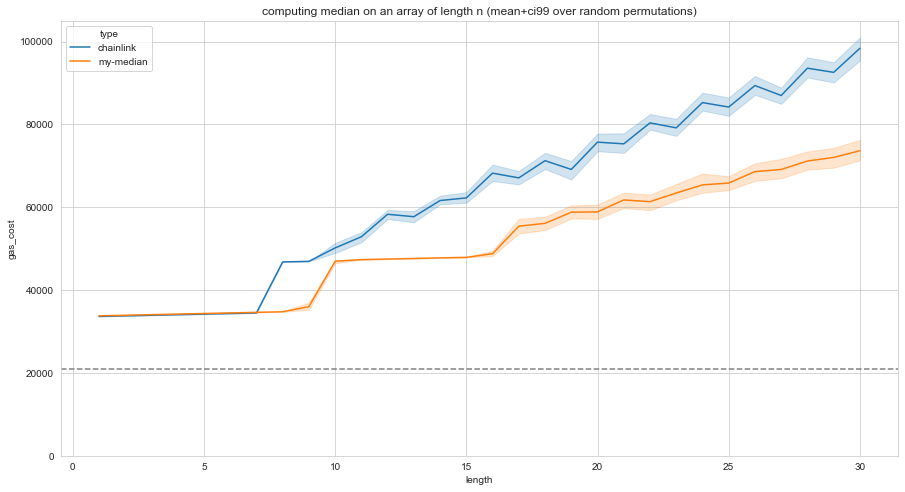

In [31]:
sns.set_style("whitegrid")
plt.figure(figsize=(15,8))

g = sns.lineplot(data=df, x="length", y="gas_cost", hue="type", ci=100);

g.set_title('computing median on an array of length n (mean+ci99 over random permutations)')

# mark minimum gas for any txn
plt.axhline(21_000, ls='--', color='grey')

#plt.xlim(0, 8);
plt.ylim(0,);